**Object detection (YOLO, R-CNN, SSD)**

Object detection is a computer vision task that involves both:

Identifying what objects are present in an image (classification), and

Locating those objects by drawing bounding boxes around them (localization).

For every detected object, the model returns:

Class: What object it is (e.g., "dog", "car", "person").

Confidence score: How sure the model is (e.g., 0.92).

Bounding box: The (x, y, width, height) coordinates of the object in the image.

**Understanding R-CNN (Regions with Convolutional Neural Networks)**

R-CNN is one of the earliest and most influential models for object detection and it uses a two-step process:

1. Propose regions in the image where objects might be.

2. Then, classify each region and fine-tune the box.


Architecture:

1. Region Proposal (Selective Search)
The algorithm looks at the image and proposes ~2000 regions (aka "region proposals") that might contain objects.

It’s like asking: “Where could there be an object?”

2. Feature Extraction (CNN)
Each proposed region is cropped and resized to a fixed size (e.g., 224×224).

Each region is passed through a CNN (like AlexNet) to get a feature vector.

3. Object Classification (SVM)
The CNN feature vector is passed into a Support Vector Machine (SVM) to classify the object in that region.

4. Bounding Box Regression
A separate regression model is used to refine the bounding box coordinates (to make them more precise).


R-CNN output For each region:

Class label (e.g., "dog", "car")

Bounding box (x, y, width, height)

Confidence score

Then apply Non-Maximum Suppression to eliminate duplicate detections.

In [ ]:
def rcnn_pipeline(image):
    # Step 1: Generate region proposals
    region_proposals = selective_search(image)

    results = []

    for region in region_proposals:
        resized = resize(region, (224, 224))

        # Step 2: Feature extraction
        features = cnn(resized)

        # Step 3: Classification
        class_label = svm_classifier(features)

        # Step 4: Box regression
        box = bbox_regressor(features)

        results.append((class_label, box))

    # Post-processing: Remove overlaps
    final_detections = non_max_suppression(results)
    return final_detections

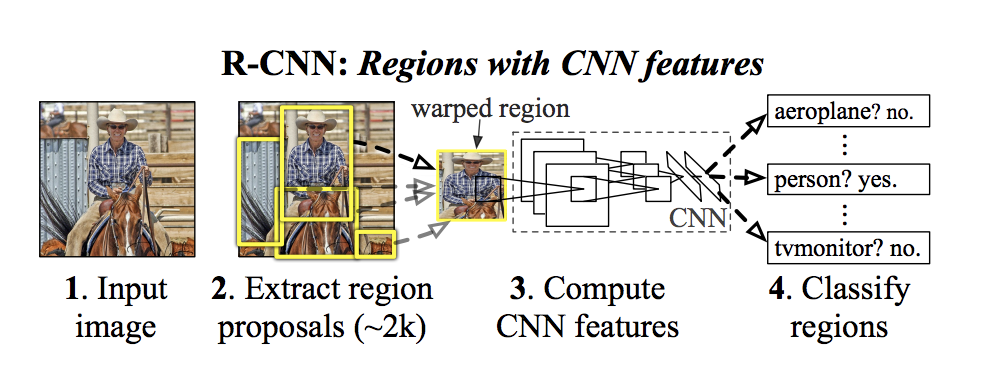

**Understanding YOLO [(You only Look Once)](https://arxiv.org/pdf/1506.02640)**

The YOLO model is a real time model used for object detection with extremely fast performance based on its ability to predict everything in a single forward pass through the network.

It tells you what objects are in an image and where they are using bounding boxes.

The original YOLOv1 architecture is based on a modified version of GoogLeNet (without Inception modules):

Architecture:

The Input Layer takes an image of size 448 × 448 × 3 and passes the image to

Convolutional Layers (24 of them) which extract features like edges, shapes, textures.

Each layer applies filters to detect different visual patterns.


The Convolutional Layer then passes the extracted features to Fully Connected Layers (2 of them) which convert the features into predictions:

One for the bounding boxes

One for the class labels

Output Layer

Output is a S × S × (B × 5 + C) tensor:

S × S: the image is divided into a grid (e.g., 7×7)

B: number of boxes per grid cell (e.g., 2)

5: (x, y, w, h, confidence)

C: number of classes (e.g., 20 in VOC)

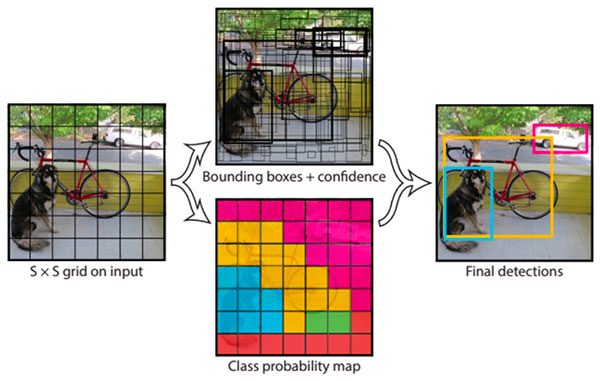

Let’s say we feed an image of a street with people and cars:

Image is divided into a grid (e.g., 7×7)

Each grid cell is responsible for detecting objects whose center falls inside it.

For each grid cell, the model predicts:

2 bounding boxes with confidence scores

Class probabilities

Post-processing:

Multiply confidence score by class probability

Apply Non-Maximum Suppression to remove duplicates; why?

When a CNN-based object detector (like Faster R-CNN, SSD, YOLO, etc.) scans an image, it doesn’t just predict one bounding box per object.
Instead, it often predicts multiple overlapping boxes for the same object, each with a confidence score.

Non-Maximum Suppression (NMS) is a post-processing step used to:

Pick the best bounding box (the one with the highest confidence score).

Suppress (remove) all other boxes that overlap significantly with it (i.e., redundant predictions).

In [5]:
def yolo_forward_pass(image):
    grid = split_image_into_grid(image, S=7)
    features = conv_layers(grid)  # CNN extracts features
    output = fully_connected(features)  # Predict (x, y, w, h, conf, classes)

    final_predictions = post_process(output)  # Confidence threshold + NMS
    return final_predictions


YOLO’s loss function combines:

Localization loss for bounding box coordinates (x, y, w, h)

Confidence loss for objectness score

Classification loss for class probabilities

All these are added up and trained using gradient descent.


**Understanding SDD (Single Shot MultiBox Detector)**

Similar to YOLO, SDD is a single-shot algorithm which detects everything in one forward pass through the network without using region proposals like R-CNN.

Unlike YOLO though, SSD detects objects at multiple scales and feature layers, making it better at detecting small objects.


Architecture:

1. A CNN (like VGG16 or MobileNet) is used to extract features from the image but not just the final layer, SSD also uses intermediate layers to detect objects at different sizes.

2. SSD adds extra convolutional layers after the backbone to create feature maps of decreasing size:

For example: 38×38, 19×19, 10×10, 5×5, 3×3, 1×1

This allows SSD to detect small and large objects effectively.

3. At each cell in every feature map, SSD predicts:

Multiple bounding boxes (anchors) with different shapes (ratios and scales),

A confidence score for each class per box,

A bounding box offset to adjust the anchor box.

Think of SSD as placing a small grid over the image and checking different boxes at every cell.

4. After generating all possible box predictions (thousands of them), SSD applies NMS (Non-Maximum Suppression) to remove overlapping boxes and keep only the best ones.


What SSD Outputs:

For each anchor box:

Class probabilities (e.g., cat: 0.9, dog: 0.1, person: 0.01…)

Bounding box offsets (dx, dy, dw, dh)

Then boxes are filtered using:

A confidence threshold (e.g., only keep boxes where cat score > 0.5)

Non-Maximum Suppression

In [ ]:
def ssd_pipeline(image):
    # Step 1: Feature extraction at multiple layers
    features = backbone_cnn(image)  # e.g., VGG

    predictions = []

    for feature_map in features:
        for cell in feature_map:
            for anchor_box in predefined_boxes:
                class_scores, box_offsets = predict(cell, anchor_box)
                predictions.append((class_scores, box_offsets))

    # Step 2: Apply Non-Max Suppression
    final_detections = non_max_suppression(predictions)
    return final_detections

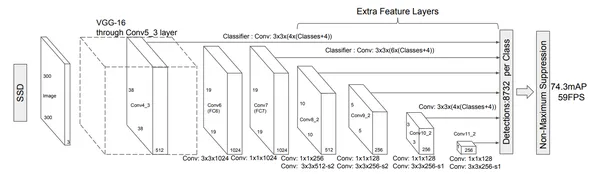

**Image segmentation**

> What is Image segmentation?

Image segmentation is a computer vision task where the goal is to label each pixel in an image with a class — essentially breaking the image into meaningful parts.


> Image segmentation Types

**Semantic Segmentation**	Classifies each pixel into a category (e.g., car, road, person)	“All car pixels = red”


**Instance Segmentation**	Same as semantic, but also distinguishes different instances of the same class	“Car 1 = red, Car 2 = green”


**Panoptic Segmentation**	Combines both semantic and instance segmentation	Best of both worlds



> Example Applications

**Medical imaging**: Identify tumors, organs

**Autonomous vehicles**: Segment roads, pedestrians, vehicles

**Agriculture**: Segment crops vs weeds

**Satellite imagery**: Classify land cover types


> Image Segmentation Architectures

U-Net: 	Designed for biomedical image segmentation

FCN: 	Fully Convolutional Network

DeepLab: 	Advanced segmentation with atrous convolutions

Mask R-CNN: 	Adds segmentation on top of object detection

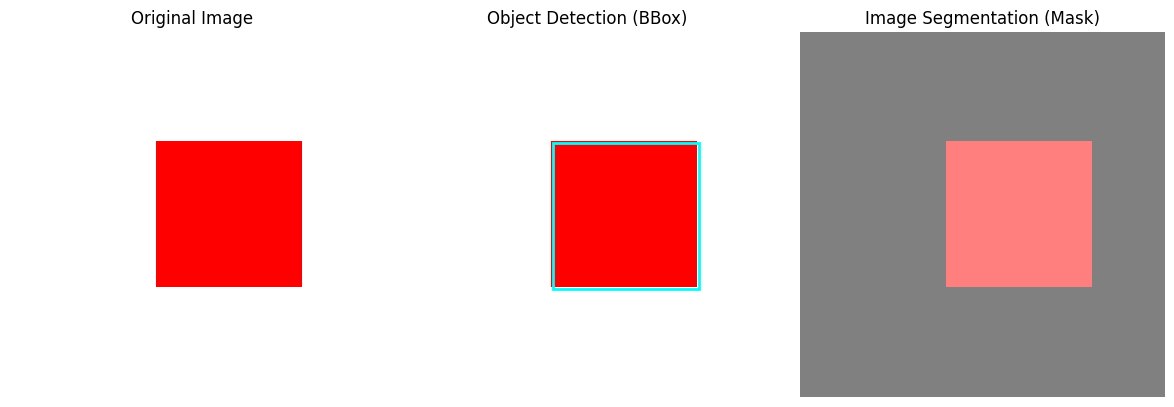

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Simulate a "toy image" (just for visualization, 100x100 pixels)
image = np.ones((100, 100, 3))  # White background

# Simulate an "object" — a red square
image[30:70, 40:80] = [1, 0, 0]  # Red square = the object

# Simulate a segmentation mask
segmentation_mask = np.zeros((100, 100))
segmentation_mask[30:70, 40:80] = 1  # 1 for the object, 0 for background

# Simulate object detection output (bounding box)
bbox = (40, 30, 40, 40)  # (x, y, width, height)

# --- Plotting the comparison ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Original image
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")

# Object Detection
axs[1].imshow(image)
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                         linewidth=2, edgecolor='cyan', facecolor='none')
axs[1].add_patch(rect)
axs[1].set_title("Object Detection (BBox)")
axs[1].axis("off")

# Image Segmentation
axs[2].imshow(image)
axs[2].imshow(segmentation_mask, alpha=0.5, cmap='gray')
axs[2].set_title("Image Segmentation (Mask)")
axs[2].axis("off")

plt.tight_layout()
plt.show()


Image Segmentation differs from Object detection in use case with a classic illustration - Object detection serves in counting & tracking objects	while Image Segmentation helps in understanding exact object boundaries.

**TensorFlow/Keras and PyTorch
frameworks**

In [ ]:
!pip install torch torchvision matplotlib pillow

In [ ]:
import gdown

file_id = "1WsSgNoQ8fqu-A4f-OjpGJkY_OfTm_EBz"
download_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(download_url, "lion_hunts_zebra.jpg")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 52.9MB/s]


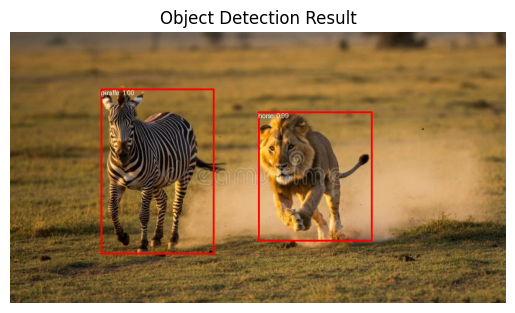

In [3]:
import numpy as np
import torch
import torchvision
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import requests
from io import BytesIO

def load_image(image_path_or_url):
    if image_path_or_url.startswith("http"):
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path_or_url).convert("RGB")
    return image


def get_coco_instance_category_names():
    """
    Returns the list of class names used in COCO dataset.
    These correspond to the class labels predicted by torchvision object detection models.
    """
    return [
        '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
        'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
        'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
        'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
        'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
        'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
        'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
        'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
        'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
    ]

# simple object detection with Pytorch

# 1. Load Pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# 2. Load an image
image = load_image("lion_hunts_zebra.jpg")

# 3. Preprocess image
input_tensor = torchvision.transforms.functional.to_tensor(image)
input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

# 4. Run object detection
with torch.no_grad():
    predictions = model(input_tensor)[0]

# 5. Draw results
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

# Only show boxes with high confidence
threshold = 0.8

COCO_INSTANCE_CATEGORY_NAMES = get_coco_instance_category_names()

for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
    if score > threshold:
        box = box.tolist()
        label_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{label_name}: {score:.2f}", fill="white", font=font)

# 6. Show result
plt.imshow(image)
plt.axis("off")
plt.title("Object Detection Result")
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


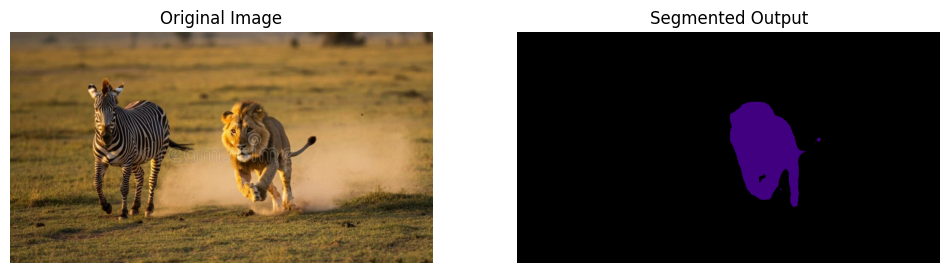

In [6]:
# simple Image Segmentation with Pytorch

# Transform image for model
def preprocess(image):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Convert segmentation output to colored mask
def decode_segmap(mask):
    # Define simple color palette (COCO has 21 classes in DeepLab)
    label_colors = np.array([
        (0, 0, 0),       # background
        (128, 0, 0),     # aeroplane
        (0, 128, 0),     # bicycle
        (128, 128, 0),   # bird
        (0, 0, 128),     # boat
        (128, 0, 128),   # bottle
        (0, 128, 128),   # bus
        (128, 128, 128), # car
        (64, 0, 0),      # cat
        (192, 0, 0),     # chair
        (64, 128, 0),    # cow
        (192, 128, 0),   # dining table
        (64, 0, 128),    # dog
        (192, 128, 0),   # horse
        (64, 128, 128),  # motorbike
        (192, 128, 128), # person
        (0, 64, 0),      # potted plant
        (128, 64, 0),    # sheep
        (0, 192, 0),     # sofa
        (128, 192, 0),   # train
        (0, 64, 128),    # tv/monitor
    ])

    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    for l in range(0, len(label_colors)):
        idx = mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Main segmentation function
def segment_image(image_path_or_url):
    image = load_image(image_path_or_url)
    input_tensor = preprocess(image)

    # Load pre-trained DeepLabV3 model
    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

    # Decode the segmentation map
    segmented_image = decode_segmap(output_predictions)

    # Show original and segmented image
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(segmented_image)
    axs[1].set_title("Segmented Output")
    axs[1].axis("off")

    plt.show()


segment_image("lion_hunts_zebra.jpg")

**Build a real-time object detection
system that can identify and track
multiple objects in video streams.**